In [1]:
import os
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image
from PIL import UnidentifiedImageError

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
#===============importing the dataset from the directory========================#
Healthy = os.listdir("D:\kaggle\input\diabetic-retinopathy-dataset\Healthy")
Mild = os.listdir('D:\kaggle\input\diabetic-retinopathy-dataset\Mild DR')
Moderate = os.listdir('D:\kaggle\input\diabetic-retinopathy-dataset\Moderate DR')
Proliferate = os.listdir('D:\kaggle\input\diabetic-retinopathy-dataset\Proliferate DR')
Severe = os.listdir('D:\kaggle\input\diabetic-retinopathy-dataset\Severe DR')

In [3]:
img_w, img_h = 225, 225 #setting the image width and height for easy processing
X = []
y = []

for i in Healthy:
    try:
        img = Image.open("D:\\kaggle\\input\\diabetic-retinopathy-dataset\\Healthy\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(0)
    except UnidentifiedImageError: # it passes an image that wasn't correctly identified
        pass
    
for i in Mild:
    try:
        img = Image.open("D:\\kaggle\\input\\diabetic-retinopathy-dataset\\Mild DR\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass
    
for i in Moderate:
    try:
        img = Image.open("D:\\kaggle\\input\\diabetic-retinopathy-dataset\\Moderate DR\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass
    
for i in Proliferate:
    try:
        img = Image.open("D:\\kaggle\\input\\diabetic-retinopathy-dataset\\Proliferate DR\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(2)
    except UnidentifiedImageError:
        pass
    
for i in Severe:
    try:
        img = Image.open("D:\\kaggle\\input\\diabetic-retinopathy-dataset\\Severe DR\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(2)
    except UnidentifiedImageError:
        pass
    
X = np.asarray(X)
y = np.asarray(y)
print(X.shape, y.shape)

# I resized each image to our manually defined width and height(img_w, img_h)
# I also changed the images to an array


(125, 225, 225, 3) (125,)


In [5]:
x = X.astype('float32')
x /= 255

num_classes = 3

labels = keras.utils.to_categorical(y, num_classes)
print(labels[0])

[1. 0. 0.]


In [6]:
# splitting our dataset into train and test
x_train1, x_test, y_train1, y_test = train_test_split(x, labels, test_size = 0.1, random_state=5)
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,test_size=0.1,random_state=5)


print('Number of train: {}'.format(len(x_train)))
print('Number of validation: {}'.format(len(x_val)))
print('Number of test: {}'.format(len(x_test)))

Number of train: 100
Number of validation: 12
Number of test: 13


In [7]:
# An image data generator is a tool provided by keras to easily perform data augmentation on images
# Data augmentation simply takes an image for instance and adds different ways the image can be presented
# for example like rotating the image, flipping the image, changing the scale e.t.c
# when training the images, data augmentation is done in real time while the image is undergoing training
# which makes it very remarkable and awesome to use
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20.,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=30.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=0.2,
    vertical_flip=0.2,
    rescale=None)

datagen.fit(x_train)

In [8]:
base_model = tf.keras.applications.InceptionV3(input_shape=(225,225,3),include_top=False,weights="imagenet")

In [9]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [10]:
# My neural network consists of 3 layers densely connected
# dropout helps prevent over fitting of the model when testing it
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary() # printing out the summary of the model for better understanding for you

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6553728   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 28,373,411
Trainable params: 6,570,819
Non-trainable params: 21,802,592
____________________________________

In [23]:

#plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
#Image(filename='convnet.png')

In [11]:
# here i am defining my performance metrics to check the performance of the model
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 3*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [12]:
lrd = ReduceLROnPlateau(monitor = 'recall',patience = 2,verbose = 1,factor = 0.50, min_lr = 1e-6)
# the above line of code reduces the learning rate when there is no improvement to the metric
# i added this line of code because i trained the model without it and the performance was stagnant
# the performance was stuck on 0.96nnn as the accuracy so i added the line of code to reduce
# the learing rate after two epochs
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=5)

model.compile(optimizer='Adam', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)

In [13]:
# this is where i fit and trained my model
%time
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

Wall time: 0 ns
Epoch 1/5
4/4 [==============================] - 128s 15s/step - loss: 9.5497 - accuracy: 0.4900 - precision: 0.5125 - recall: 0.4100 - auc: 0.6294 - f1_score: 0.6818 - val_loss: 8.9442 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 0.6667 - val_auc: 0.7500 - val_f1_score: 1.0000
Epoch 2/5
4/4 [==============================] - 44s 10s/step - loss: 2.2313 - accuracy: 0.7600 - precision: 0.7600 - recall: 0.7600 - auc: 0.8798 - f1_score: 1.1367 - val_loss: 1.0396 - val_accuracy: 0.5833 - val_precision: 0.5833 - val_recall: 0.5833 - val_auc: 0.8368 - val_f1_score: 0.8750
Epoch 3/5
4/4 [==============================] - 43s 10s/step - loss: 0.7537 - accuracy: 0.8400 - precision: 0.8400 - recall: 0.8400 - auc: 0.9370 - f1_score: 1.3125 - val_loss: 1.8423 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 0.6667 - val_auc: 0.8472 - val_f1_score: 1.0000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/5
4/4 [=====

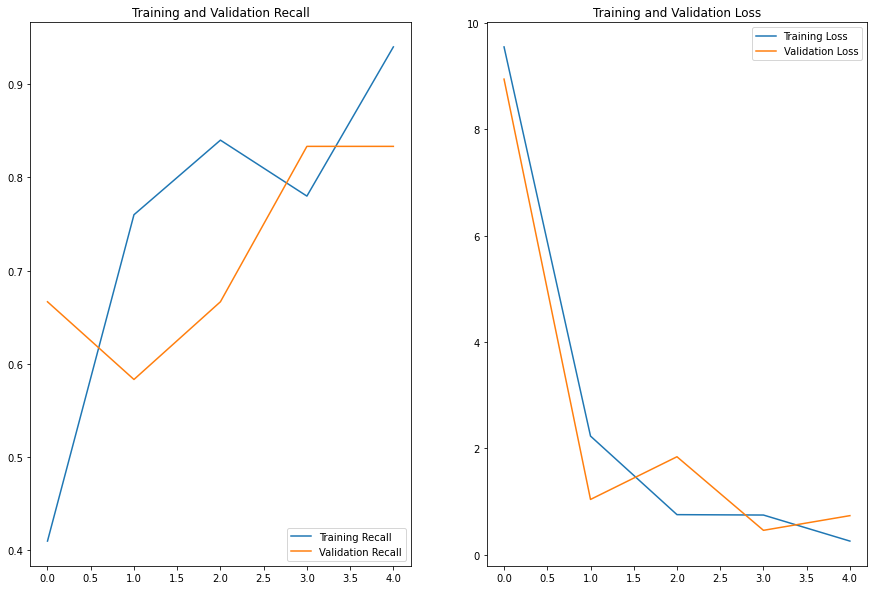

In [14]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Recall')
plt.plot(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Healty       1.00      1.00      1.00         8
 not healthy       1.00      1.00      1.00         5

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13



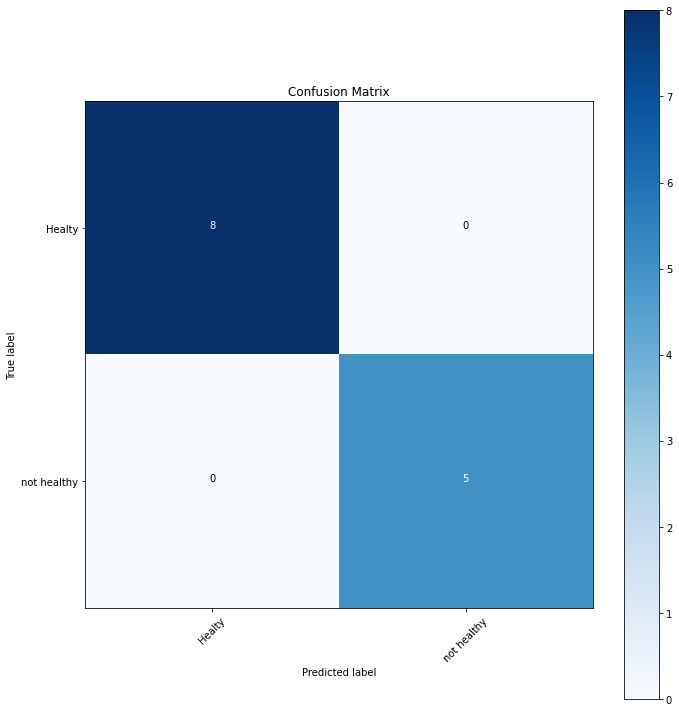

In [16]:
# here i want to define and plot my confusion matrix
# and also my classification report
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
y_pred = (model.predict(x_test) > 0.5).astype("int32")

y_test_c = np.argmax(y_test, axis=1)
target_names = ["Healty", "not healthy"]

Y_pred = np.argmax(model.predict(x_test),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))


#=====================important note==============================#
# this model i created basically classifies different cases into 3 and they are
# healthy(meaning the eye is healthy and free from any retinopathy)
# caution(meaning the eye has some detected disfunctionalities and immediate treatemet has to commence
# before it worsens)
# and severe(meaning that the eye is under serious attack from by retinopathy and in severe condition)
# so its either the eye is healthy severe or needs to be treated with caution